In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('cleaned data.csv')
df.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,24932-239347,Al Mamoura,Licensed,"Al Mamoura, Al Muroor District",Abu Dhabi,AZ,AE,51133,Not avaiable,GMT+04:00 Asia/Dubai,54.39,24.46
2,Starbucks,24931-239348,Raha Garden,Licensed,Raha Gardens Plaza,Abu Dhabi,AZ,AE,51133,Not avaiable,GMT+04:00 Asia/Dubai,54.37,24.47
3,Starbucks,27072-246650,Reel Cinema,Licensed,"Reel Cinema, Dubai Mall, Second Floor",Dubai,DU,AE,113444,Not avaiable,GMT+04:00 Asia/Muscat,55.60,24.78
4,Starbucks,25406-240945,Bin Sougat,Licensed,"Al Khawaneej Road, Al Rashidiya",Dubai,DU,AE,10170,Not avaiable,GMT+04:00 Asia/Dubai,55.40,25.23


In [6]:
df.shape

(22622, 13)

Let's create some hypothetical sceanrio, we'd be adding these fatures to our source data(adding extra features won't change the previous features) - 

Potential: total capacity in terms of staff (e.g. 10 means that the store can have up to 10 employees)

Staff: current staff level (e.g. 7 means that the store is currently operating with 7 employees)

Capacity: current left capacity (e.g. 10–7=3, the store can still host 3 employees)
Cost: annual cost for the company to keep the store operating (“low”, “medium”, “high”)

In [78]:
df["Potential"] = np.random.randint(low=3, high=10+1, size=len(df))
df["Staff"] = df["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
df["Capacity"] = df["Potential"] - df["Staff"]
df["Cost"] = np.random.choice(["high","medium","low"], size=len(df), p=[0.4,0.5,0.1])
df.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Potential,Staff,Capacity,Cost
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51,6,2,4,high
1,Starbucks,24932-239347,Al Mamoura,Licensed,"Al Mamoura, Al Muroor District",Abu Dhabi,AZ,AE,51133,Not avaiable,GMT+04:00 Asia/Dubai,54.39,24.46,10,7,3,low
2,Starbucks,24931-239348,Raha Garden,Licensed,Raha Gardens Plaza,Abu Dhabi,AZ,AE,51133,Not avaiable,GMT+04:00 Asia/Dubai,54.37,24.47,6,6,0,low
3,Starbucks,27072-246650,Reel Cinema,Licensed,"Reel Cinema, Dubai Mall, Second Floor",Dubai,DU,AE,113444,Not avaiable,GMT+04:00 Asia/Muscat,55.60,24.78,6,4,2,high
4,Starbucks,25406-240945,Bin Sougat,Licensed,"Al Khawaneej Road, Al Rashidiya",Dubai,DU,AE,10170,Not avaiable,GMT+04:00 Asia/Dubai,55.40,25.23,7,5,2,medium


In [79]:
df.describe()

,Longitude,Latitude,Potential,Staff,Capacity
count,22621.000000,22621.000000,22622.000000,22622.000000,22622.000000
mean,-37.107338,36.119728,6.486562,3.748740,2.737822
std,94.914676,11.728042,2.283123,2.281772,2.271502
min,-159.460000,-36.790000,3.000000,1.000000,0.000000
25%,-111.010000,32.970000,5.000000,2.000000,1.000000
50%,-81.680000,37.430000,6.000000,3.000000,2.000000
75%,29.020000,41.880000,8.000000,5.000000,4.000000
max,143.200000,64.850000,10.000000,10.000000,9.000000


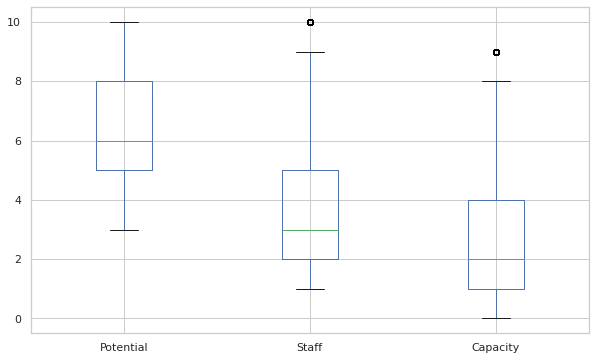

In [90]:
df[['Potential','Staff','Capacity']].plot(kind = 'box', figsize = (10,6))

## Data Analysis


Let’s pretend we own a retail business and we have to close some stores. We would want to do that maximizing the profit (by minimizing the cost) and without laying off any staff.

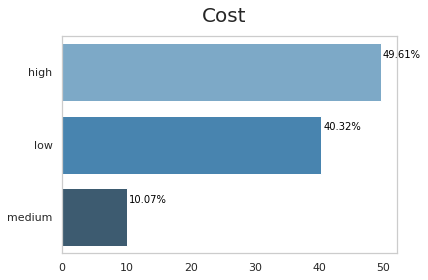

In [87]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(y = df['Cost'].unique(),x = df['Cost'].value_counts().values/df.shape[0]*100,
                    orient = 'h',
                    palette="Blues_d"
            )
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle('Cost', fontsize=20)
plt.show()

for i in ax.patches:
  
  print(i)


Returns:

Rectangle(xy=(0, -0.4), width=49.6066, height=0.8, angle=0)

Rectangle(xy=(0, 0.6), width=40.3192, height=0.8, angle=0)

Rectangle(xy=(0, 1.6), width=10.0743, height=0.8, angle=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


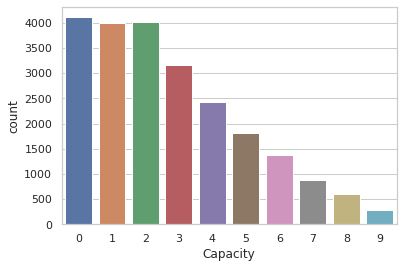

In [91]:
sns.countplot(df.Capacity)

From the above plot we see that many of the stores are not working at full-capacity. Here 0 indicates full capacity,i.e.no additional person is required

Now we'll try to analyze these information with geopy.  I need to get the coordinates of the geographic area to start up the map. I shall do that with geopy

In [92]:
## for geospatial
import folium
import geopy

In [93]:
city = "Las Vegas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States
[lat, long]: [36.1672559, -115.148516]


I am going to create the map with folium, a really convenient package that allows us to plot interactive maps without needing to load a shapefile. Each store shall be identified by a point with size proportional to its current staff and color based on its cost. I’m also going to add a small piece of HTML code to the default map to display the legend.

In [94]:
x, y = "Latitude", "Longitude"
color = "Cost"
size = "Staff"
popup = "Street Address"
data = df.copy()

In [95]:
## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(df[color].unique()))
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

In [ ]:
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_